In [253]:
#!pip install langchain
#!pip install pinecone-client
#!pip install openai
#!pip install matplotlib
#%pip install --upgrade tiktoken
#%pip install --upgrade openai

In [254]:
# # Define your environment variables as a dictionary
# env_variables = {
#     'OPENAI_API_KEY': OPENAI_API_KEY,
#     'PINECONE_API_KEY': PINECONE_API_KEY,
#     'PINECONE_ENV': PINECONE_ENV,
#     # Add more variables as needed
# }

# # Write the environment variables to .env file
# with open('.env', 'w') as f:
#     for key, value in env_variables.items():
#         f.write(f'{key}={value}\n')

# Load dependencies

In [255]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
import time

from langchain.document_loaders import WebBaseLoader
from langchain.vectorstores import Pinecone
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
#from langchain.llms import OpenAI
from langchain.memory import VectorStoreRetrieverMemory
#from langchain.chains import ConversationChain
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.chains import RetrievalQAWithSourcesChain

import pinecone

In [256]:
OPENAI_API_KEY= ""
PINECONE_API_KEY=""
PINECONE_ENV= "gcp-starter"

# Functions

In [257]:
def num_tokens_from_string(text):
    """Returns the number of tokens in a text string."""
    encoding = tokenizer
    num_tokens = len(encoding.encode(text))
    return num_tokens 

def calculate_statistics(data):
    # Calculate basic statistics
    try:
        mode_value = statistics.mode(data)
    except statistics.StatisticsError:
        mode_value = None  # In case there's no unique mode

    return {
        'mean': statistics.mean(data),
        'median': statistics.median(data),
        'mode': mode_value,
        'variance': statistics.variance(data),
        'standard_deviation': statistics.stdev(data),
        'min': min(data),
        'max': max(data)
    }


# Load documentation

In [258]:
data_links = pd.read_csv('./data/ibm_links.csv') .links.to_list()

In [287]:
# Assuming data is a list of Document objects loaded by WebBaseLoader
loader = WebBaseLoader(data_links)
data = loader.load()

# This dictionary will map document content to the shortest source link and the document itself
content_to_document_map = {}

for doc in data:
    doc_content = doc.page_content
    doc_source = doc.metadata['source']
    
    # Check if the document content is already in the map
    # and if the current source URL is shorter than the one stored
    if (doc_content not in content_to_document_map or 
            len(doc_source) < len(content_to_document_map[doc_content]['source'])):
        content_to_document_map[doc_content] = {
            'source': doc_source,
            'document': doc  # Storing the document object directly
        }

# Now that we have our unique documents, we can create two lists
unique_sources = [details['source'] for details in content_to_document_map.values()]
unique_documents = [details['document'] for details in content_to_document_map.values()]

In [291]:
data = unique_documents

In [292]:
len(data)

39

In [294]:
#data

In [295]:
data[0]

Document(page_content="\n\n\n\n\n\n\nMetadata - IBM Generative AI Python SDK (Tech Preview)\n\n\n\n\n\n\n\n\n\nContents\n\n\n\n\n\nMenu\n\n\n\n\n\n\n\nExpand\n\n\n\n\n\nLight mode\n\n\n\n\n\n\n\n\n\n\n\n\n\nDark mode\n\n\n\n\n\n\nAuto light/dark mode\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nHide navigation sidebar\n\n\nHide table of contents sidebar\n\n\n\n\n\nToggle site navigation sidebar\n\n\n\n\nIBM Generative AI Python SDK (Tech Preview)\n\n\n\n\nToggle Light / Dark / Auto color theme\n\n\n\n\n\n\nToggle table of contents sidebar\n\n\n\n\n\n\n\nIBM Generative AI Python SDK (Tech Preview)\n\n\n\n\n\n\nAPIs:\n\nGENAIToggle navigation of GENAI\nCredentials\nMetadata\nModel\n\n\nServicesToggle navigation of Services\nRequest Handler\nService Interface\n\n\nSchemasToggle navigation of Schemas\nDescriptions\nGenerate\nHistory\nResponses\nToken\nTunes\nFiles\n\n\nPromptsToggle navigation of Prompts\nQuick Start\nBasic Concepts\nAnnexe\nPrompts Pattern\n\n\nExceptionsToggle navigation of Exceptions\n

# Check histogram of token_lengths (to check that we can make embeddings out of input texts)

In [296]:
# https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

tokenizer  = tiktoken.get_encoding("cl100k_base")

In [297]:
txt = list(data[0])[0][1]

In [298]:
num_tokens_from_string(txt)

535

In [299]:
links_length = []

# Example usage:
input_text = "Calculate the OpenAI input length in tokens."
print("Approximate token count:", openai_approx_token_count(txt))
for i in data:
    len_txt = num_tokens_from_string(list(i)[0][1])
    links_length.append(len_txt)

Approximate token count: 381


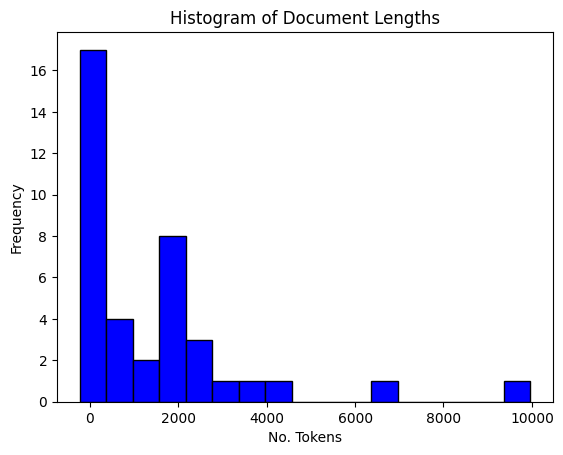

In [300]:
# Calculate bin width
bin_width = 600  # You can change this value to adjust the width of the bins

# Create bins with the specified width
bins = range(min(links_length), max(links_length) + bin_width, bin_width)

# Create histogram
plt.hist(links_length, bins=bins, align='left', color='blue', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Document Lengths')
plt.xlabel('No. Tokens')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [301]:
# Example usage:
stats = calculate_statistics(links_length)

for stat, value in stats.items():
    print(f"{stat.capitalize()}: {value}")

Mean: 1764.2051282051282
Median: 911
Mode: 432
Variance: 3939287.0620782725
Standard_deviation: 1984.7637295351485
Min: 68
Max: 10154


In [62]:
#links_length

### Because I use code to be transfered into embeddings, I split on hithest threshold in terms of tokens

In [302]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 5000, # 8150 max
    chunk_overlap  = 300,
    length_function = num_tokens_from_string,
    add_start_index = True,)

texts = text_splitter.split_documents(data)
#texts = data

In [303]:
#print(list(texts[0])[0][1])

In [304]:
len(texts)

42

In [305]:
texts[0]

Document(page_content="Metadata - IBM Generative AI Python SDK (Tech Preview)\n\n\n\n\n\n\n\n\n\nContents\n\n\n\n\n\nMenu\n\n\n\n\n\n\n\nExpand\n\n\n\n\n\nLight mode\n\n\n\n\n\n\n\n\n\n\n\n\n\nDark mode\n\n\n\n\n\n\nAuto light/dark mode\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nHide navigation sidebar\n\n\nHide table of contents sidebar\n\n\n\n\n\nToggle site navigation sidebar\n\n\n\n\nIBM Generative AI Python SDK (Tech Preview)\n\n\n\n\nToggle Light / Dark / Auto color theme\n\n\n\n\n\n\nToggle table of contents sidebar\n\n\n\n\n\n\n\nIBM Generative AI Python SDK (Tech Preview)\n\n\n\n\n\n\nAPIs:\n\nGENAIToggle navigation of GENAI\nCredentials\nMetadata\nModel\n\n\nServicesToggle navigation of Services\nRequest Handler\nService Interface\n\n\nSchemasToggle navigation of Schemas\nDescriptions\nGenerate\nHistory\nResponses\nToken\nTunes\nFiles\n\n\nPromptsToggle navigation of Prompts\nQuick Start\nBasic Concepts\nAnnexe\nPrompts Pattern\n\n\nExceptionsToggle navigation of Exceptions\nGENAI Exceptio

# Prepare pinecone vector database

In [306]:
pinecone.init(
            api_key= PINECONE_API_KEY, # set api_key = 'yourapikey'
            environment= PINECONE_ENV
)

In [307]:
pinecone.list_indexes()

['brainsoft']

In [309]:
index_n = "brainsoft"
if index_n not in pinecone.list_indexes():
    pinecone.create_index(name=index_n, dimension=1536, metric='cosine')

index_name = pinecone.Index(index_n)

# Initialize OpenAI API

In [310]:
embeddings_model = OpenAIEmbeddings(model = 'text-embedding-ada-002', # 8191 tokens
                                    openai_api_key=OPENAI_API_KEY) # set openai_api_key = 'your_openai_api_key'

In [311]:
llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY, 
                 model_name='gpt-3.5-turbo-16k',
                 #max_tokens = 10000,
                 temperature=0) # gpt-3.5-turbo-16k 'gpt-3.5-turbo'
llm.predict("Hello world!")

'Hello! How can I assist you today?'

# Create embeddings from texts and save it to vector database

In [312]:
start_time = time.time()

vectordb = Pinecone.from_documents(texts, embeddings_model, index_name=index_n)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The code block took {elapsed_time} seconds to run.")

The code block took 2.0808331966400146 seconds to run.


# Create chain

In [351]:
# Define a template message
# Always say "thanks for asking!" at the end of the answer. 
# If you don't know the answer, just say that you don't know, don't try to make up an answer.
# Answer with python script only!
#Use three sentences maximum and keep the answer as concise as possible.
template = """Use the following pieces of context to answer the question at the end.  
{context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [352]:
retriever = vectordb.as_retriever(search_kwargs={'k': 1})
memory = ConversationBufferMemory(memory_key="chat_history",input_key='question', output_key='answer', return_messages= True)
#memory = VectorStoreRetrieverMemory(retriever=retriever, input_key='question', output_key='answer', return_messages= True)

chain = ConversationalRetrievalChain.from_llm(llm, 
                                              retriever = retriever, 
                                              combine_docs_chain_kwargs={"prompt": QA_CHAIN_PROMPT},
                                              return_source_documents=True, 
                                              memory = memory) # chain chain verbose=True

In [353]:
# Generation

In [354]:
chat_history = []
query = 'Show an examples of Alice Bob QA in python ?'
result = chain({"question": query, "chat_history": chat_history}) # "chat_history": chat_history
print(result["answer"])

The example of Alice Bob QA in Python can be found in the code snippet labeled "Alice Bob QA" in the provided context.


In [355]:
len(result["source_documents"])

1

In [356]:
#chat_history = [(query, result["answer"])]
query = "ok, but I want you to write python script!"
result = chain({"question": query, "chat_history": chat_history})
print(result['answer'])

Sure! Here's a Python script for Alice Bob QA:

```python
import os
import time

from dotenv import load_dotenv

from genai.credentials import Credentials
from genai.model import Model
from genai.schemas import GenerateParams

# make sure you have a .env file under genai root with
# GENAI_KEY=<your-genai-key>
# GENAI_API=<genai-api-endpoint>
load_dotenv()
api_key = os.getenv("GENAI_KEY", None)
api_endpoint = os.getenv("GENAI_API", None)

print("\n------------- Example (Model QA)-------------\n")

max_cycles = 20

bob_params = GenerateParams(
    decoding_method="sample",
    max_new_tokens=25,
    min_new_tokens=1,
    stream=False,
    temperature=1,
    top_k=50,
    top_p=1,
)

alice_params = GenerateParams(
    decoding_method="sample",
    max_new_tokens=45,
    min_new_tokens=1,
    stream=False,
    temperature=0.05,
    top_k=50,
    top_p=1,
)

creds = Credentials(api_key, api_endpoint)
bob_model = Model("google/flan-ul2", params=bob_params, credentials=creds)
alice_model = Mo

In [357]:
chat_history.append((query, result["answer"]))
query = "From your last output, what does mean the 5th argument in GenerateParams and why is it set just like it is?"
result = chain({"question": query, "chat_history": chat_history})
print(result['answer'])

The 5th argument in GenerateParams is the "min_new_tokens" parameter. It is set to "None" in the last output because it is an optional argument and its default value is not specified in the provided context.


In [358]:
chat_history.append((query, result["answer"]))
query = "Isnt it temperature ?"
result = chain({"question": query, "chat_history": chat_history})
print(result['answer'])

Yes, the 5th argument in GenerateParams is the "temperature" parameter. It is set to "float | None" which means it can accept a floating-point number or be set to None. The reason for this is to provide flexibility in specifying the temperature value for generating text. If a specific temperature value is desired, it can be set as a float. If no temperature value is specified, it can be set to None and the default value will be used.


In [361]:
chat_history.append((query, result["answer"]))
query = "Provide only first sentence from your last message!"
result = chain({"question": query, "chat_history": chat_history})
print(result['answer'])

The 5th argument in GenerateParams is "min_new_tokens". It is set to None by default. This argument specifies the minimum number of tokens that should be generated before considering any stop sequences. If stop sequences are given, they are ignored until the minimum number of tokens specified by this argument is generated.
